# Problem statement
This is a airline passengers month and yearly data from github sources, It is preprocessed raw data. Our task to predict monthly airline passengers prediction.

## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)

## Loading the data 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/Live-Time-Series/main/airline_passengers.csv")
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


# Data Preprocessing

In [3]:
# Checking the missing value 
df.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [4]:
# Check the last five rows of the dataset
df.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [5]:
# Drop the missing values
df.dropna(axis = 0, inplace = True)

In [6]:
# Check data type, number of features, records, missing value etc
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [7]:
# Convert the month column data type from object to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [8]:
# Checking the month column conversion confirmation
df.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [9]:
# Set month column as index column for time series analysis
df.set_index('Month', inplace = True)

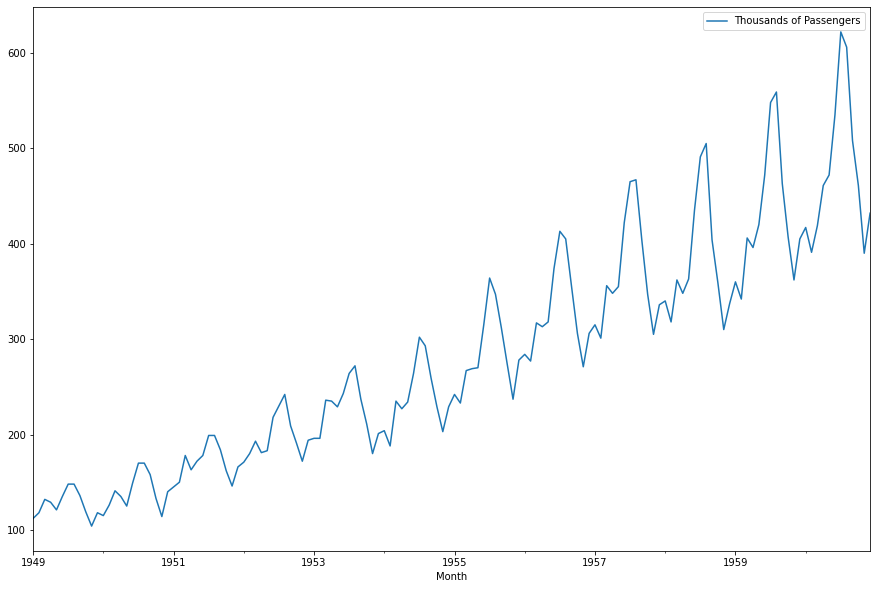

In [10]:
# View the datset in line plot
df.plot();

Observation: The dataset is looks seasonal and not stationary, It flows up and down. But we are not confirm. To make it confirmation we need to Dickey fuller test called ADFuller test.

## Adam Dickey Fuller Test 
- First attempt to confirm that data is stationary or not, if not we have to make it stationary for prediction.
- By doing this test we can confirm that data is stationary or not from its p-value.

In [11]:
# define function for data checking stationary or not
def adf_test(series):
    result = adfuller(series)
    print("ADF statistics: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis, reject null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has unit root, indicating it is not stationary ")
        

In [12]:
# Testing data for stationary or not 
adf_test(df['Thousands of Passengers'])

ADF statistics: 0.8153688792060569
p-value: 0.9918802434376411
Weak evidence against null hypothesis, time series has unit root, indicating it is not stationary 


In [13]:
# testing with first difference
df["passenger first difference"] = df['Thousands of Passengers']-df['Thousands of Passengers'].shift(1)

In [14]:
df.head()

,Thousands of Passengers,passenger first difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


In [15]:
# Testing data for stationary or not 
adf_test(df['passenger first difference'].dropna())

ADF statistics: -2.8292668241699928
p-value: 0.05421329028382636
Weak evidence against null hypothesis, time series has unit root, indicating it is not stationary 


In [16]:
# Use 2nd difference technique
df["passenger 2nd difference"] = df["passenger first difference"]-df["passenger first difference"].shift(1)

In [17]:
# Testing data for stationary or not 
adf_test(df['passenger 2nd difference'].dropna())

ADF statistics: -16.384231542468505
p-value: 2.7328918500142407e-29
Strong evidence against null hypothesis, reject null hypothesis. Data has no unit root and is stationary


In [18]:
# Use whole season 12 months difference technique
df["passenger 12 difference"] = df["Thousands of Passengers"] - df["Thousands of Passengers"].shift(12)

In [19]:
# Testing data for stationary or not 
adf_test(df['passenger 12 difference'].dropna())

ADF statistics: -3.383020726492481
p-value: 0.011551493085514952
Strong evidence against null hypothesis, reject null hypothesis. Data has no unit root and is stationary


Observation: According to above adfuller test we will count 2nd and 12 time difference for passengers count prediction.
These two test has stationary data.

## Second test Autocorrelation(ACF) and partial Autocorrelation(PACF)
- Autocorrelation for moving average and partial correlation for Auto regression value.
- p for pacf and q for acf, d for time difference.
- we count the p and q value which points cross the lower and upper boundary of PACF and ACF curve. Those points are our p and q value. 

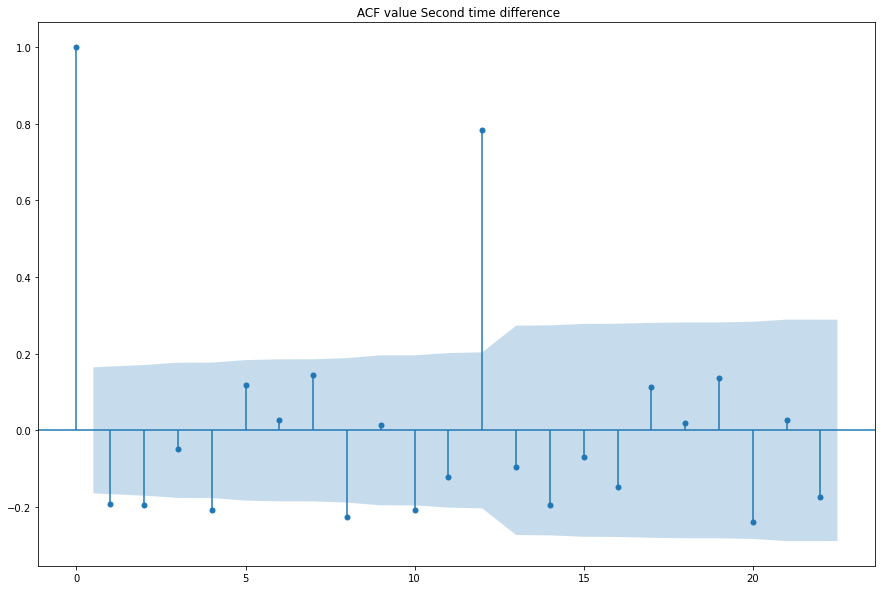

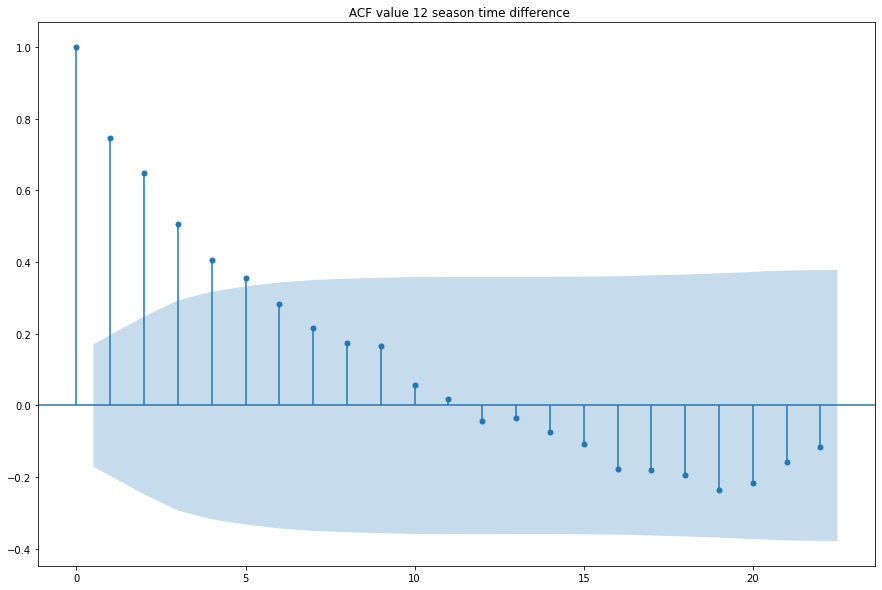

In [20]:
acf = plot_acf(df['passenger 2nd difference'].dropna(), title=" ACF value Second time difference")
acf12 = plot_acf(df['passenger 12 difference'].dropna(), title=" ACF value 12 season time difference")

Observation: ACF for 2nd time difference we can count 6points as q value and for 12 season 5 points. 

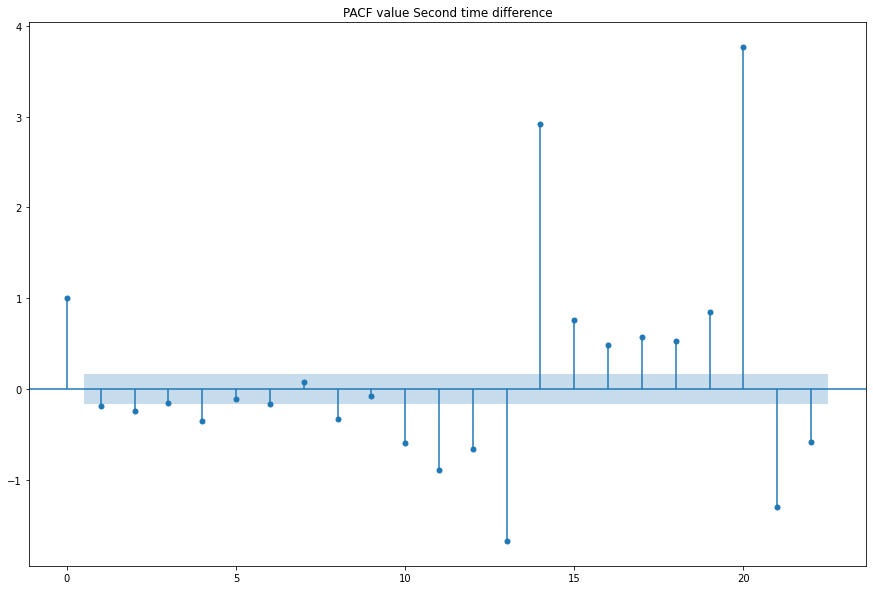

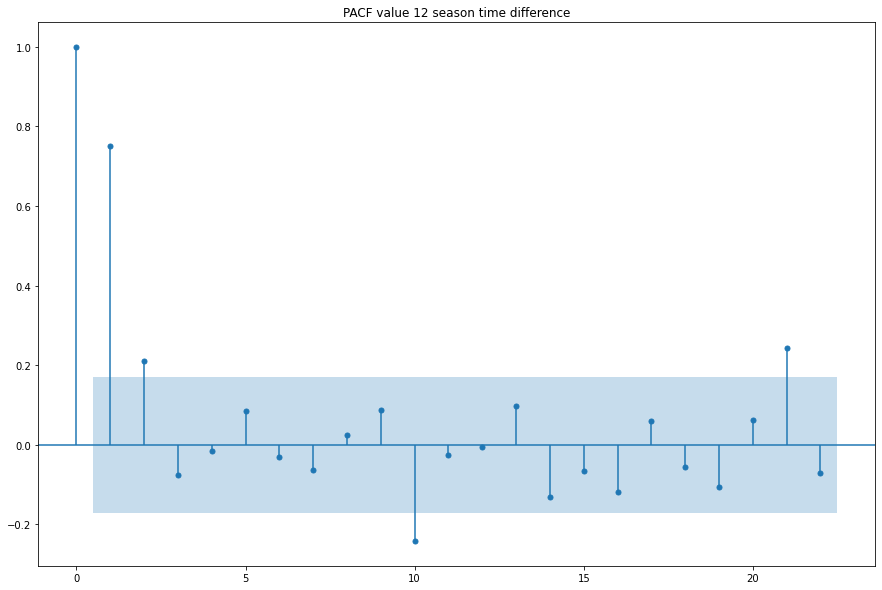

In [21]:
pacf = plot_pacf(df['passenger 2nd difference'].dropna(), title="PACF value Second time difference")
pacf12 = plot_pacf(df['passenger 12 difference'].dropna(), title="PACF value 12 season time difference")

Observation: From PACF chart we can count p value for 2nd time difference almost all points where for 12 season only 3 points.
As we so far about stationary data and p, q value idea so now we can train model and play with that values.

# Split the train and test data

In [22]:
# Lets have a quick look of the data
df

,Thousands of Passengers,passenger first difference,passenger 2nd difference,passenger 12 difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1960-08-01,606.0,-16.0,-103.0,47.0
1960-09-01,508.0,-98.0,-82.0,45.0
1960-10-01,461.0,-47.0,51.0,54.0


Observation: We have data from 1949 to 1960, about 12 years data with monthly period. We can select 7 years data for training and 5 years for testing purpose.

In [23]:
from datetime import datetime, timedelta
train_dataset_end = datetime(1955,12,1) # 7 yrs period til that date
test_dataset_end = datetime(1960,12,1) # 5 yrs period til that date

In [24]:
train_data = df[:train_dataset_end]
test_data = df[train_dataset_end + timedelta(days = 1):test_dataset_end]

In [25]:
train_data.shape

(84, 4)

In [26]:
test_data.shape

(60, 4)

In [27]:
# View the prediction data from test data
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [28]:
test_data.index[0]

Timestamp('1956-01-01 00:00:00')

In [29]:
test_data.index[-1]

Timestamp('1960-12-01 00:00:00')

# Create an ARIMA model

In [30]:
from statsmodels.tsa.arima_model import ARIMA

In [31]:
model_arima = ARIMA(train_data["Thousands of Passengers"], order = (10,2,0)) # p=10, difference(d) = 2, q=0

In [32]:
model_arima.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.Thousands of Passengers   No. Observations:                   82
Model:                        ARIMA(10, 2, 0)   Log Likelihood                -357.239
Method:                               css-mle   S.D. of innovations             18.333
Date:                        Tue, 08 Mar 2022   AIC                            738.477
Time:                                00:01:04   BIC                            767.358
Sample:                            03-01-1949   HQIC                           750.072
                                 - 12-01-1955                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0164      0.347      0.047      0.962      -0.665       0.697
ar.L1.D2.Thousands of Passengers     -0.5165      0.097     -5.300      0.000      -0.707      -0.325
ar.L2.D2.Thousands of Passengers     -0.7203      0.108     -6.650      0.000      -0.933      -0.508
ar.L3.D2.Thousands of Passengers     -0.4856      0.120     -4.032      0.000      -0.722      -0.250
ar.L4.D2.Thousands of Passengers     -0.7506      0.131     -5.717      0.000      -1.008      -0.493
ar.L5.D2.Thousands of Passengers     -0.5065      0.151     -3.360      0.001      -0.802      -0.211
ar.L6.D2.Thousands of Passengers     -0.5204      0.149     -3.500      0.000      -0.812      -0.229
ar.L7.D2.Thousands of Passengers     -0.3055      0.136     -2.250      0.024      -0.572      -0.039
ar.L8.D2.Thousands of Passengers     -0.5943      0.125     -4.744      0.000      -0.840      -0.349
ar.L9.D2.Thousands of Passengers     -0.2966      0.116     -2.556      0.011      -0.524      -0.069
ar.L10.D2.Thousands of Passengers    -0.4826      0.101     -4.765      0.000      -0.681      -0.284
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9098           -0.5670j            1.0720           -0.0887
AR.2             0.9098           +0.5670j            1.0720            0.0887
AR.3             0.4844           -0.9210j            1.0406           -0.1729
AR.4             0.4844           +0.9210j            1.0406            0.1729
AR.5            -0.9676           -0.4146j            1.0527           -0.4356
AR.6            -0.9676           +0.4146j            1.0527            0.4356
AR.7            -0.6004           -0.8889j            1.0726           -0.3445
AR.8            -0.6004           +0.8889j            1.0726            0.3445
AR.9            -0.1335           -1.1349j            1.1427           -0.2686
AR.10           -0.1335           +1.1349j            1.1427            0.2686
------------------------------------------------------------------------------
"""

## Model Prediction

In [33]:
pred = model_arima.fit().predict(start=pred_start_date, end = pred_end_date)
residuals = test_data["Thousands of Passengers"]-pred

In [34]:
pred[:5]

1956-01-01   -18.695974
1956-02-01   -12.830797
1956-03-01    -2.329672
1956-04-01   -15.562154
1956-05-01    19.310686
Freq: MS, dtype: float64

In [35]:
residuals[:5]

Month
1956-01-01    302.695974
1956-02-01    289.830797
1956-03-01    319.329672
1956-04-01    328.562154
1956-05-01    298.689314
dtype: float64

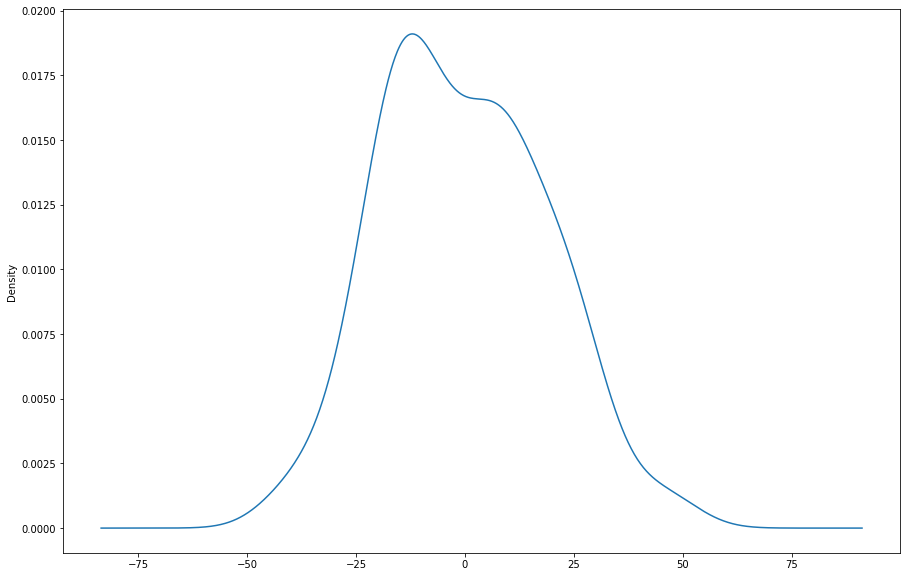

In [36]:
model_arima.fit().resid.plot(kind = "kde");

In [37]:
test_data["predicted_arima"] = pred

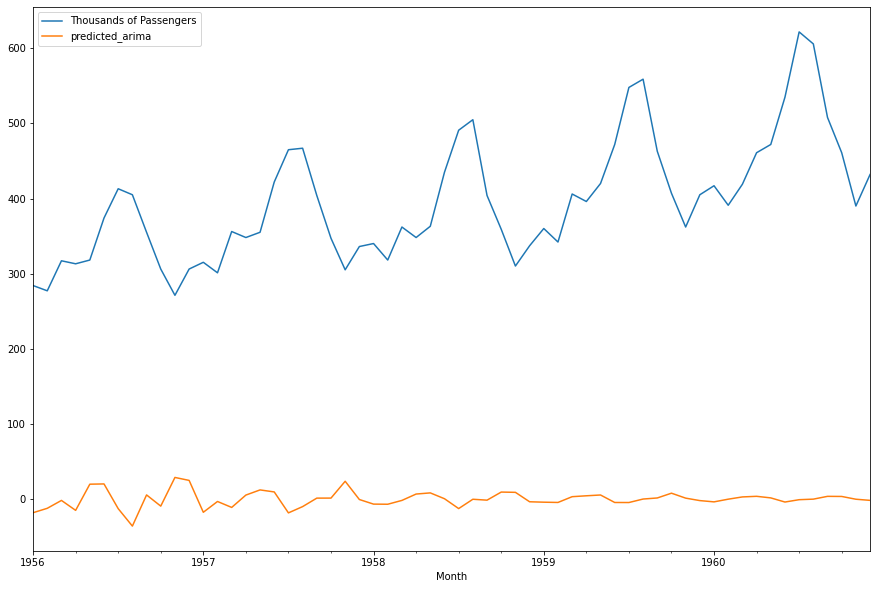

In [38]:
# plot both actual and predicted value
test_data[["Thousands of Passengers", "predicted_arima"]].plot();

Observation: 
- Its big difference between actual and predicted model. 
- It because for seasonal data ARIMA model is not best choice, SARIMAX working better for seasonal data. 
- ARIMA is good for non seasonal data like stock data. 
- We will see next phase using SARIMAX model result. 

# Create a SARIMAX model

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
model_SARIMA=SARIMAX(train_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

In [41]:
model_SARIMA_fit=model_SARIMA.fit()

In [42]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.240
Date:                             Tue, 08 Mar 2022   AIC                            548.481
Time:                                     00:01:19   BIC                            568.971
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5980      0.938      0.638      0.524      -1.240       2.436
ar.L2          0.8311      0.232      3.582      0.000       0.376       1.286
ar.L3         -0.4522      0.894     -0.506      0.613      -2.204       1.300
ma.L1          0.1840      1.165      0.158      0.874      -2.099       2.467
ma.L2         -0.5339      1.263     -0.423      0.672      -3.009       1.941
ma.L3         -0.0987      0.384     -0.257      0.797      -0.852       0.655
ma.L4         -0.1273      0.338     -0.377      0.706      -0.789       0.535
ma.L5          0.2471      0.357      0.692      0.489      -0.452       0.947
sigma2        87.7341     81.252      1.080      0.280     -71.516     246.984
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
test_data.tail()

,Thousands of Passengers,passenger first difference,passenger 2nd difference,passenger 12 difference,predicted_arima
Month,,,,,
1960-08-01,606.0,-16.0,-103.0,47.0,-0.615668
1960-09-01,508.0,-98.0,-82.0,45.0,3.106042
1960-10-01,461.0,-47.0,51.0,54.0,2.964128
1960-11-01,390.0,-71.0,-24.0,28.0,-0.732253
1960-12-01,432.0,42.0,113.0,27.0,-2.251365


## Prediction

In [44]:
pred_Sarimax = model_SARIMA_fit.predict(start=datetime(1956,6,6),end=datetime(1960,12,1))
residuals=test_data['Thousands of Passengers']-pred_Sarimax

In [45]:
pred[:5]

1956-01-01   -18.695974
1956-02-01   -12.830797
1956-03-01    -2.329672
1956-04-01   -15.562154
1956-05-01    19.310686
Freq: MS, dtype: float64

In [46]:
residuals[:10]

1956-01-01          NaN
1956-02-01          NaN
1956-03-01          NaN
1956-04-01          NaN
1956-05-01          NaN
1956-06-01          NaN
1956-07-01     9.601691
1956-08-01    19.928582
1956-09-01     5.553902
1956-10-01    -4.218712
dtype: float64

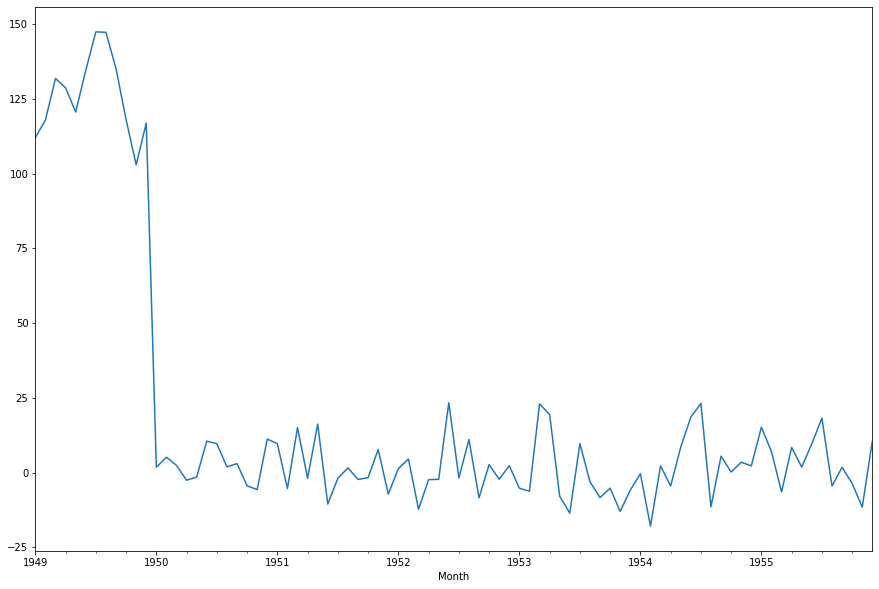

In [47]:
model_SARIMA_fit.resid.plot();

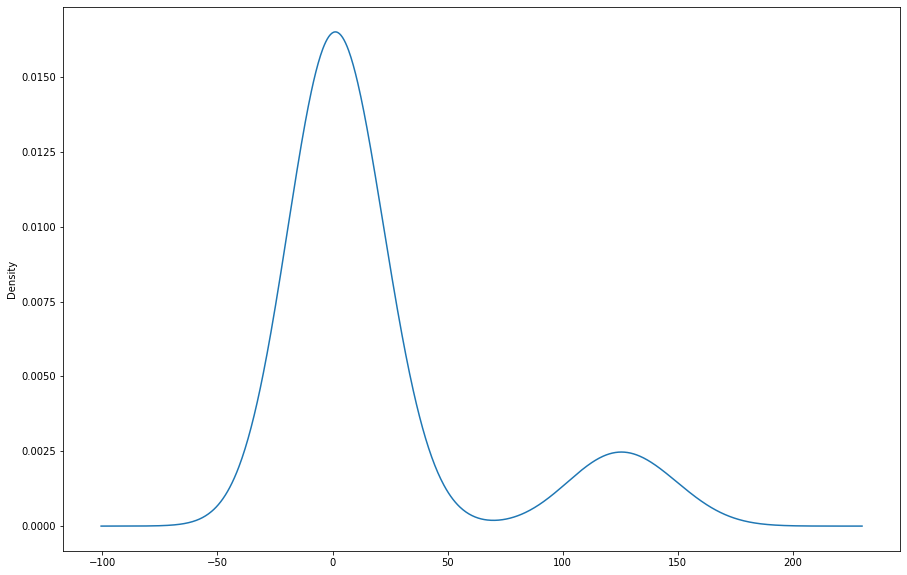

In [48]:
model_SARIMA_fit.resid.plot(kind='kde');

In [49]:
test_data['Predicted_SARIMA']=pred_Sarimax

In [50]:
test_data.head()

,Thousands of Passengers,passenger first difference,passenger 2nd difference,passenger 12 difference,predicted_arima,Predicted_SARIMA
Month,,,,,,
1956-01-01,284.0,6.0,-35.0,42.0,-18.695974,NaN
1956-02-01,277.0,-7.0,-13.0,44.0,-12.830797,NaN
1956-03-01,317.0,40.0,47.0,50.0,-2.329672,NaN
1956-04-01,313.0,-4.0,-44.0,44.0,-15.562154,NaN
1956-05-01,318.0,5.0,9.0,48.0,19.310686,NaN


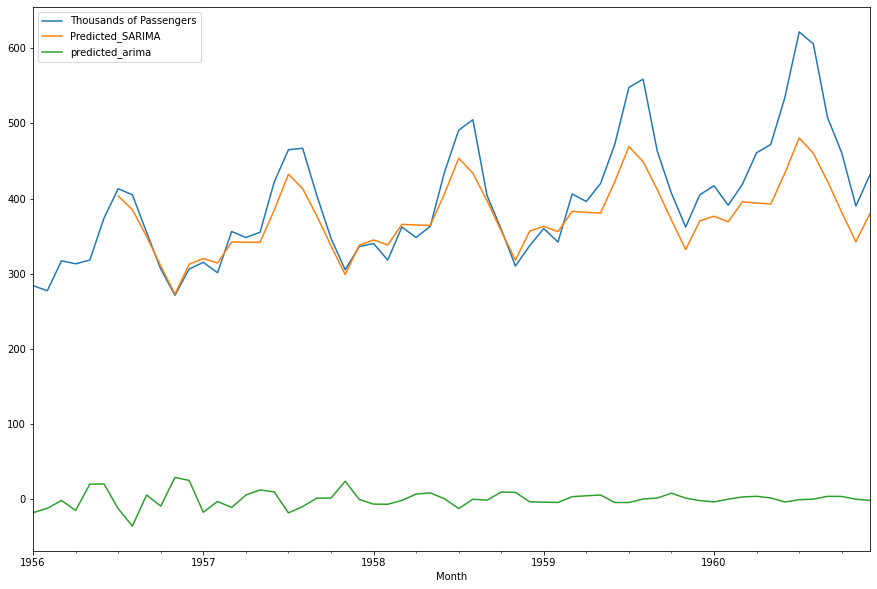

In [51]:
# plot ARIMA, SARIMAX MODEL PREDICTION WITH ACTUAL DATA.
test_data[['Thousands of Passengers','Predicted_SARIMA','predicted_arima']].plot();


Observation: From the above line graph its clearly understandable that SARIMAX model works best with seasonal data. 

# Conclusion
Last is not but least. This is a simple machine learning task for time series prediction for seasonal data. I have got transparent knowledge by doing this project. I am acknowledge to Krish Naik. Now I am able to present to audience what is time series and how to handle that for ML model prediction for forecasting. 
- I described only seasonal data and where I used model SARIMAX which best fit. 
- For non seasonal data we should use ARIMA model, that will work best for those data. We can also try and error by changing the value of p, q and d, also order. 

During practice I have tried several models by changing parameters and finalize this model which work best for my purpose, so I decided to show only this result to keep my notebook clean and simple to understand for anybody. 